# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering_and_circle_fitting

In [2]:
ids = [12]
min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"
min_speed_filter = 5

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from sklearn.cluster import DBSCAN
from pyproj import Transformer
import argparse

### Pipeline support with passing forced parameters

In [4]:
parser = argparse.ArgumentParser(
    description="Process input and output paths for video processing."
)

parser.add_argument(
    "-i", "--input", 
    help="Path to the input video file.", 
    required=False
)

parser.add_argument(
    "-o", "--output", 
    help="Path to the output folder.", 
    required=False
)

parser.add_argument(
    "--f", "--kernel_launcher", 
    help="Path to the kernel launcher file.",
    required=False
)

_StoreAction(option_strings=['--f', '--kernel_launcher'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='Path to the kernel launcher file.', metavar=None)

In [5]:
args = parser.parse_args()

if args.input and args.output:
    args = parser.parse_args()
    
    FORCE_INPUT_AND_OUTPUT_PATHS = True
    FORCED_video_file_path = args.input
    FORCED_output_folder = args.output
    print("System arguments detected:", args)
else:
    FORCE_INPUT_AND_OUTPUT_PATHS = False


### Helper

In [6]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_seconds(time_stamp:str):
    """Convert a time stamp to seconds

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The seconds since midnight
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

# Lat and Long to X and Y

In [7]:
# https://link-springer-com.manchester.idm.oclc.org/article/10.1007/s00190-023-01815-0
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    lat = np.radians(lat)
    lon = np.radians(lon)

    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

def lat_lon_to_BGS_X_Y(lat:float, lon:float):
    """Convert latitude and longitude to BGS X and Y

    Args:
        lat (float): latitude
        lon (float): longitude

    Returns:
        tuple: The BGS X and Y coordinates
    """
    # GPS - EPSG:4326  https://epsg.io/4326
    # BGS - EPSG:27700 https://epsg.io/27700
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
    bgs_format =  transformer.transform(lat, lon)

    northing = bgs_format[0]
    easting = bgs_format[1]

    return easting, northing

test_lat_kilburn = 53.4675254
test_lon_kilburn = -2.234003
test_lat_crewe = 53.09863295
test_lon_crewe = -2.45823645
test_conversion_kilburn = lat_lon_to_x_y(test_lat_kilburn, test_lon_kilburn)
test_conversion_crewe = lat_lon_to_x_y(test_lat_crewe, test_lon_crewe)
test_bsg_kilburn = lat_lon_to_BGS_X_Y(test_lat_kilburn, test_lon_kilburn)
test_bsg_crewe = lat_lon_to_BGS_X_Y(test_lat_crewe, test_lon_crewe)

print (f'Kilburn: X: {test_conversion_kilburn[0]}, Y: {test_conversion_kilburn[1]}')
print (f'Crewe: X: {test_conversion_crewe[0]}, Y: {test_conversion_crewe[1]}')
print (f'Kilburn BGS: X: {test_bsg_kilburn[0]}, Y: {test_bsg_kilburn[1]}')
print (f'Crewe BGS: X: {test_bsg_crewe[0]}, Y: {test_bsg_crewe[1]}')

conversion_distance_to_crewe = np.sqrt((test_conversion_kilburn[0] - test_conversion_crewe[0])**2 + (test_conversion_kilburn[1] - test_conversion_crewe[1])**2)
conversion_distance_to_crewe_bgs = np.sqrt((test_bsg_kilburn[0] - test_bsg_crewe[0])**2 + (test_bsg_kilburn[1] - test_bsg_crewe[1])**2)

print (f"According to google earth the distance between Kilburn and Crewe is 43,188.27 meters")
print(f'Distance between Kilburn and Crewe in meters: {conversion_distance_to_crewe}')
print(f'Distance between Kilburn and Crewe in meters (BGS): {conversion_distance_to_crewe_bgs}')

Kilburn: X: 6391116.323565937, Y: -4349.259055188549
Crewe: X: 6390995.086329557, Y: -4785.716345837706
Kilburn BGS: X: 396779.55851404776, Y: 384563.1150520657
Crewe BGS: X: 355812.82182048995, Y: 369414.1694847972
According to google earth the distance between Kilburn and Crewe is 43,188.27 meters
Distance between Kilburn and Crewe in meters: 452.98281870925007
Distance between Kilburn and Crewe in meters (BGS): 43677.958596062614


In [8]:
if FORCE_INPUT_AND_OUTPUT_PATHS:
    file_path = FORCED_video_file_path
    output_folder = FORCED_output_folder
else:
    file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 012 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends


In [9]:
# !firefox {file_path} # display the video

# Read file contents

### NMEA string extraction

In [10]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

Get the NMEA strings from the video file.

In [11]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} GPS records, of which {frame_count} frames are available')
data[:10]

Found 4002 GPS records, of which 5400 frames are available


['$GPRMC,144748.500,A,5304.67063,N,00228.00139,W,27.375,267.22,151124,,,A*6D',
 '$GPGGA,144748.500,5304.67063,N,00228.00139,W,1,13,0.82,36.3,M,49.8,M,,*51',
 '$GPRMC,144748.600,A,5304.67056,N,00228.00258,W,25.998,264.94,151124,,,A*69',
 '$GPGGA,144748.600,5304.67056,N,00228.00258,W,1,13,0.82,36.3,M,49.8,M,,*50',
 '$GPRMC,144748.700,A,5304.67050,N,00228.00382,W,26.461,264.91,151124,,,A*65',
 '$GPGGA,144748.700,5304.67050,N,00228.00382,W,1,13,0.82,36.3,M,49.8,M,,*51',
 '$GPRMC,144748.800,A,5304.67042,N,00228.00502,W,26.062,264.57,151124,,,A*6A',
 '$GPGGA,144748.800,5304.67042,N,00228.00502,W,1,13,0.82,36.3,M,49.8,M,,*53',
 '$GPRMC,144748.900,A,5304.67038,N,00228.00624,W,26.447,267.21,151124,,,A*60',
 '$GPGGA,144748.900,5304.67038,N,00228.00624,W,1,13,0.82,36.2,M,49.8,M,,*59']

NMEA string parsing and data extraction

In [12]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def DMS_to_decimal(lon:str, lon_heading:str, lat:str, lat_heading:str):
    """Convert Degrees Minutes Seconds to decimal
    lon: dddmm.mmmm
    lat: ddmm.mmmm

    Args:
        lon (str): The longitude in DMS format
        lon_heading (str): The heading for the longitude
        lat (str): The latitude in DMS format
        lat_heading (str): The heading for the latitude

    Returns:
        float, float: The latitude and longitude in decimal format
    """
    
    lon_degrees = int(lon[:3])
    lon_minutes = float(lon[3:])
    lon_decimal = lon_degrees + lon_minutes/60
    if lon_heading == 'W':
        lon_decimal = -lon_decimal

    lat_degrees = int(lat[:2])
    lat_minutes = float(lat[2:])
    lat_decimal = lat_degrees + lat_minutes/60
    if lat_heading == 'S':
        lat_decimal = -lat_decimal

    return lat_decimal, lon_decimal

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    if valid == 'V':
        return {
            "time": time,
            "valid": False
        }

    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    # Convert latitude and longitude to decimal
    numeric_lat, numeric_lon = DMS_to_decimal(longitude, lon_direction, latitude, lat_direction)

    speed = knots_to_mph(float(speed))  # Convert speed to mph
        
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": numeric_lat,
        "longitude": numeric_lon,
        "height": height,
        "speed": speed
    }

In [13]:
# parse gps records at a step of two to capture both GPRMC and GPGGA records
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

# status of the records
print(f"Found {len(positions)} positions")
num_total_valid = len([p for p in positions if p['valid']])
num_total_invalid = len([p for p in positions if not p['valid']])
print("valid positions:", num_total_valid)
print("invalid positions:", num_total_invalid)

if num_total_valid == 0:
    raise ValueError("No valid positions found")

if num_total_invalid > 0:
    print("Some positions are invalid")
    if num_total_invalid / len(positions) > 0.1:
        raise ValueError("More than 10% of the positions are invalid")

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")

Found 2001 positions
valid positions: 2001
invalid positions: 0
Unique positions: 1821


### Video Metadata extraction

In [14]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [15]:
# filter out invalid GPS records
print(f"Total positions: {len(positions)}")
positions = [p for p in positions if p['valid']]
print(f"Valid positions: {len(positions)}")

positions[:2]

Total positions: 1821
Valid positions: 1821


[{'time': '144821.700',
  'valid': True,
  'latitude': 53.0770645,
  'longitude': -2.4729816666666666,
  'height': '44.3',
  'speed': 32.24255404},
 {'time': '144822.400',
  'valid': True,
  'latitude': 53.077011666666664,
  'longitude': -2.473104833333333,
  'height': '44.4',
  'speed': 32.369139839999995}]

### Convert Lat Lon to X, Y
Convert to a 2D plane to convert out gps points to a meter based X, Y coordinate system
- improves relative distance calculation accuracy
- creates a relative scale between lon and lat
- improves clustering accuracy
- improves circle fitting accuracy

In [16]:
 
for position in positions:
    lat, lon = position['latitude'], position['longitude']
    position['x'], position['y'] = lat_lon_to_BGS_X_Y(lat, lon)


Original_Positions = positions.copy()
positions[:2]

[{'time': '144821.700',
  'valid': True,
  'latitude': 53.0770645,
  'longitude': -2.4729816666666666,
  'height': '44.3',
  'speed': 32.24255404,
  'x': 353419.8454711069,
  'y': 368411.00286853523},
 {'time': '144822.400',
  'valid': True,
  'latitude': 53.077011666666664,
  'longitude': -2.473104833333333,
  'height': '44.4',
  'speed': 32.369139839999995,
  'x': 353414.0224955892,
  'y': 368402.71284655645}]

# Plot GPS positions on graph

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

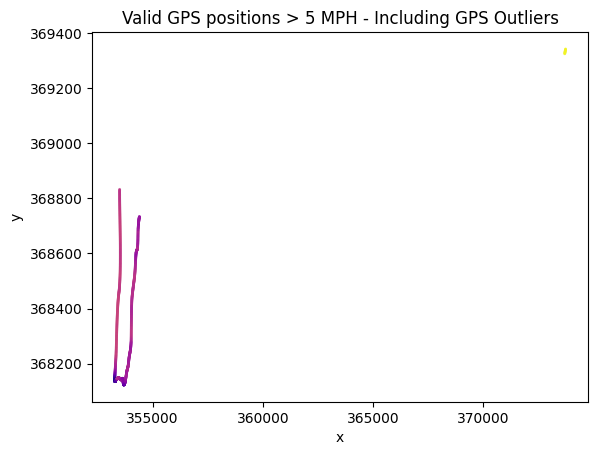

In [17]:
plt.close('all')
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

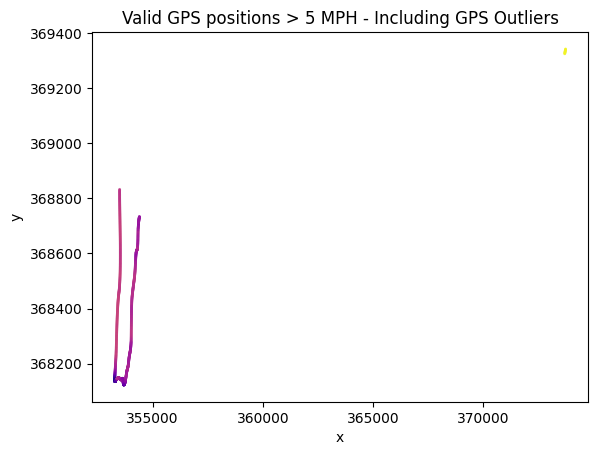

In [18]:
plt.close('all')

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

### Remove outliers from our data

Median x: 353642.1593489588
Median y: 368311.96335339634


Text(0.5, 1.0, 'Valid GPS positions > 5 MPH')

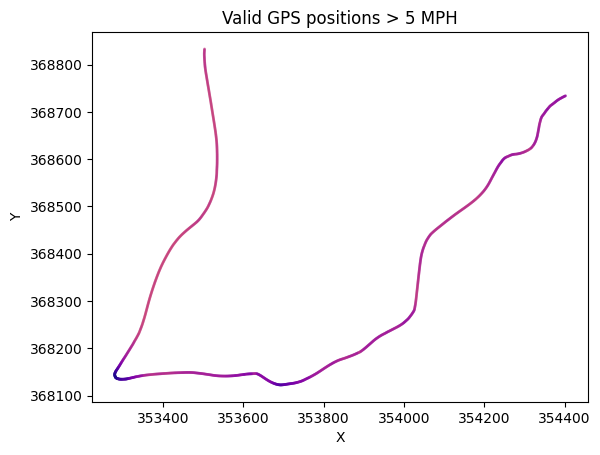

In [19]:
plt.close('all')

MIN_DISTANCE_OUTLIER_FILTER = 1000 # 1KM distance from the median

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

# calculate the median x and y
median_x = np.median(x)
median_y = np.median(y)
print(f'Median x: {median_x}')
print(f'Median y: {median_y}')

# filter out the points that are not within the MIN_DISTANCE_OUTLIER_FILTER
positions = [
    pos for pos in positions
        if abs(pos['x'] - median_x) < MIN_DISTANCE_OUTLIER_FILTER and 
            abs(pos['y'] - median_y) < MIN_DISTANCE_OUTLIER_FILTER
        ]

# plot the filtered points
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH')

In [20]:
# Get start and end time for frame estimation
positions = sorted(positions, key=lambda x: x['time'])
STARTING_TIME = time_stamp_to_seconds(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_seconds(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

Starting time: 53268500
Ending time: 53448600


### Remove invalid records and records under min_speed_filter mph

In [21]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than min_speed_filter mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < min_speed_filter:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [22]:
positions = filter_invalid_and_low_mph_records(positions)
positions = sorted(positions, key=lambda x: x['time']) # sort by time

print(f"{len(positions)} positions after filtering")
positions[:2]

1802 positions after filtering


[{'time': '144748.500',
  'valid': True,
  'latitude': 53.07784383333333,
  'longitude': -2.4666898333333336,
  'height': '36.3',
  'speed': 31.5026025,
  'x': 353503.77797975147,
  'y': 368833.07132119575},
 {'time': '144748.600',
  'valid': True,
  'latitude': 53.07784266666667,
  'longitude': -2.4667096666666666,
  'height': '36.3',
  'speed': 29.91797844,
  'x': 353503.65685044456,
  'y': 368831.74182129855}]

# Set accumulated distance in positions

In [23]:
def get_accumulated_distance(x_pos: list[float], y_pos: list[float]) -> list[float]:
    """Get the accumulated distance from x and y positions

    Args:
        x_pos (list[float]): x values
        y_pos (list[float]): y values

    Returns:
        list[float]: list of accumulated distances
    """

    distance = 0.0
    distances = [0.0]
    for i in range(1, len(x_pos)):
        dx = x_pos[i] - x_pos[i-1]
        dy = y_pos[i] - y_pos[i-1]
        distance += np.hypot(dx, dy)
        distances.append(distance)
    return distances

def set_accumulated_distance(positions: list[dict]) -> list[dict]:
    """Set the accumulated distance for the positions

    Args:
        positions (list[dict]): The list of positions

    Returns:
        list[dict]: The list of positions with accumulated distance
    """
    x_pos = [float(pos['x']) for pos in positions]
    y_pos = [float(pos['y']) for pos in positions]
    distances = get_accumulated_distance(x_pos, y_pos)
    for i in range(len(positions)):
        positions[i]['distance'] = distances[i]
    return positions

positions = set_accumulated_distance(positions)
positions[:2]

[{'time': '144748.500',
  'valid': True,
  'latitude': 53.07784383333333,
  'longitude': -2.4666898333333336,
  'height': '36.3',
  'speed': 31.5026025,
  'x': 353503.77797975147,
  'y': 368833.07132119575,
  'distance': 0.0},
 {'time': '144748.600',
  'valid': True,
  'latitude': 53.07784266666667,
  'longitude': -2.4667096666666666,
  'height': '36.3',
  'speed': 29.91797844,
  'x': 353503.65685044456,
  'y': 368831.74182129855,
  'distance': np.float64(1.335006474007011)}]

# Find bends

In [24]:
def apply_median_filter(records:list[float], size:int = 5):
    """Apply a median filter to a list

    Args:
        records (list[float]): The list of points
        size (int, optional): Kernel size. Defaults to 5.

    Returns:
        list[float]: The filtered points
    """

    temp = records.copy() # create a copy to avoid modifying the original list
    # slide a window of size 2*size+1 over the records
    for i in range(size, len(records)-size):
        temp[i] = np.median(records[i-size:i+size])
    return temp

In [25]:
def get_smoothed_sequence_angles(x_pos:list[float], y_pos:list[float], meters:int = 5) -> list[float]:
    """Get the smoothed sequence angles from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The smoothed sequence angles
    """

    x_pos = apply_median_filter(x_pos, 5)
    y_pos = apply_median_filter(y_pos, 5)

    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)

    accumulated_distance = get_accumulated_distance(x_pos, y_pos)

    angles = []

    for i in range(1, len(accumulated_distance)):
        # find all positions within 5 meters before and after the current position
        current_distance = accumulated_distance[i]
        low_distance = max(0, current_distance - meters)
        high_distance = min(accumulated_distance[-1], current_distance + meters)

        low_index = np.searchsorted(accumulated_distance, low_distance, side='left')
        high_index = np.searchsorted(accumulated_distance, high_distance, side='right')
        high_index = min(high_index, len(accumulated_distance))

        # print(low_index, i, high_index)

        # Before vector (from low_index to i)
        before_vector = np.array([
            np.sum(diff_x[low_index:i]), 
            np.sum(diff_y[low_index:i])
        ])
        

        # After vector (from i to high_index)
        after_vector = np.array([
            np.sum(diff_x[i:high_index]), 
            np.sum(diff_y[i:high_index])
        ])
        
        # Check zero vectors
        if np.linalg.norm(before_vector) == 0 or np.linalg.norm(after_vector) == 0:
            angles.append(0.0)
            continue
        
        # Compute angle using vector operations
        dot = np.dot(before_vector, after_vector)
        cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)
        angle = np.arctan2(cross, dot)
        
        angles.append(angle)

    angles_rad = np.array(angles)
    complex_angles = np.exp(1j * angles_rad)

    # smooth angles with gaussian filter
    gaussian = np.exp(-np.linspace(-2, 2, 5)**2)
    gaussian /= gaussian.sum()
    smoothed_complex = np.convolve(complex_angles, gaussian, mode='same')

    # Convert back to angles
    smoothed_angles = np.angle(smoothed_complex)
    smoothed_degrees = np.degrees(smoothed_angles)

    return smoothed_degrees

### Config parameters for bend ROI findings

In [26]:
lower_threshold = 5  # degrees
DB_SCAN_EPS = 10
DB_SCAN_MIN_SAMPLES = 3

/tmp/ipykernel_30650/494813718.py:54: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)


Found 1801 angles
[2.69300885 2.97755785 3.68726    4.08934031 4.53334266]


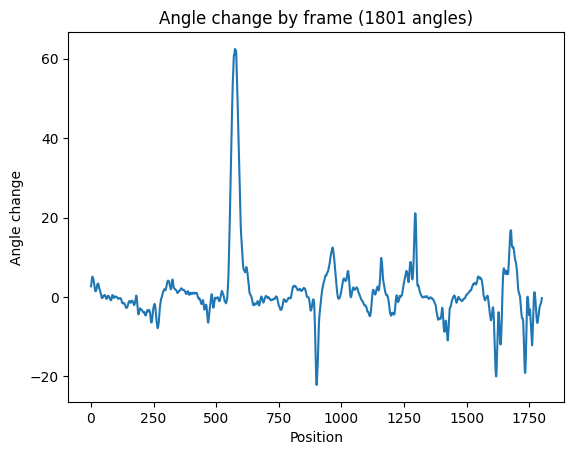

In [27]:
plt.close('all')

positions_ordered_by_time = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))

x_pos = [pos['x'] for pos in positions_ordered_by_time]
y_pos = [pos['y'] for pos in positions_ordered_by_time]
speeds = [pos['speed'] for pos in positions_ordered_by_time]

angles = get_smoothed_sequence_angles(x_pos, y_pos, meters=10)

print(f"Found {len(angles)} angles")
print(angles[:5])

# angles_derivative = np.gradient(angles) # get the first derivative of the angles

angles_derivative = angles # get the first derivative of the angles

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.savefig(os.path.join(output_folder, "angle_graph.png"))

Found 1 bends
[ 5.01806839  5.10800946 -5.42292211 -6.09517195 -6.38087501]
Found 17 bends after clustering


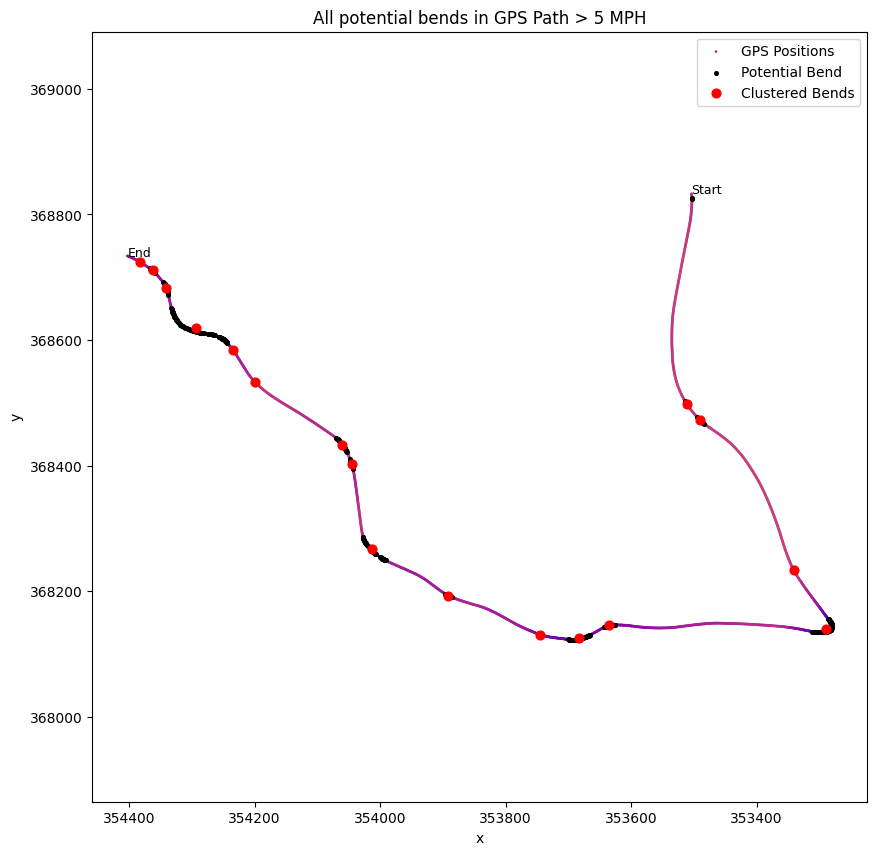

In [28]:
plt.close('all')

# bends above the threshold
bends = np.where(np.abs(angles_derivative) > lower_threshold)

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:5])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy() # Store the potential bends for plotting later

# bends = cluster.vq.kmeans(bends_positions, )[0] # not applicable since we need to know K
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=DB_SCAN_EPS, min_samples=DB_SCAN_MIN_SAMPLES, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    cluster_centers = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    cluster_centers = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(cluster_centers)} bends after clustering")

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

# add start and end points TEXT LABEL
plt.text(
    x_pos[0],
    y_pos[0],
    'Start',
    fontsize=9,
    color='black'
)

plt.text(
    x_pos[-1],
    y_pos[-1],
    'End',
    fontsize=9,
    color='black'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:,0],
        cluster_centers[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])

# set size
plt.gcf().set_size_inches(10, 10)
plt.title(f"All potential bends in GPS Path > {min_speed_filter} MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.axis('equal')
plt.gca().invert_xaxis()


plt.savefig(os.path.join(output_folder, "bends.png"))

In [29]:
print(f"total of {len(cluster_centers)} potential bend clusters found")
cluster_centers

total of 17 potential bend clusters found


array([[353511.6443848 , 368498.33809172],
       [353489.6574762 , 368471.76320071],
       [353340.90297517, 368232.89884151],
       [353290.0495607 , 368140.01090343],
       [353634.6059591 , 368145.22356529],
       [353683.22850603, 368124.72302905],
       [353745.21442306, 368130.59911224],
       [353891.56641218, 368192.87302006],
       [354012.58468372, 368266.63224704],
       [354045.49273096, 368402.91252077],
       [354060.96505659, 368433.34649088],
       [354199.11793152, 368532.76834085],
       [354234.60588393, 368584.42744189],
       [354293.78350487, 368618.3728899 ],
       [354341.01216537, 368683.2452595 ],
       [354362.6046921 , 368710.74621491],
       [354383.21602877, 368724.85803898]])

### Estimate relevant frames

In [30]:
def time_stamp_to_frame_number(time_stamp:str, STARTING_TIME:int = STARTING_TIME, END_TIME:int = END_TIME, total_frames:int = total_frames):
    """Estimate frame number using the timestamp

    Args:
        time_stamp (str): The time stamp to convert
        STARTING_TIME (int, optional): video starting time stamp. Defaults to STARTING_TIME.
        END_TIME (int, optional): video ending timestamp. Defaults to END_TIME.
        total_frames (int, optional): total number of frames. Defaults to total_frames.

    Returns:
        int: frame number
    """
    # calculate the difference between the time stamp and the starting time
    diff = time_stamp_to_seconds(time_stamp) - STARTING_TIME

    total_time = END_TIME - STARTING_TIME

    # print(f"diff: {diff}, toal_time: {total_time}")

    if total_time <= 0:
        return 0
    
    # estimate the frame number
    predict_frame_number = int((diff / total_time) * total_frames)
    
    return predict_frame_number

def get_closest_position_based_on_lat_lon(x:float, y:float, positions:list[dict]):
    """Get the closest position based on x and y

    Args:
        lat (float): x
        lon (float): y
        positions (list[dict], optional): list of all positions. Defaults to positions.

    Returns:
        dict: The closest position
    """
    min_distance = float('inf')
    closest_position = None

    # print(positions[:5])

    for position in positions:
        p_x = position['x']
        p_y = position['y']
        distance = np.sqrt((p_x - x)**2 + (p_y - y)**2)

        if distance < min_distance:
            min_distance = distance
            closest_position = position

    return closest_position


def get_frame_number_based_on_bend_x_y(cluster_centers:list[list[float]], positions:list[dict] = positions):
    """Get the frame number based on the bend x and y for each cluster center

    Args:
        cluster_centers (list[list[float]]): list of cluster centers
        positions (list[dict], optional): list of considered positions. Defaults to positions.

    Returns:
        list[int]: list of frame numbers
    """
    frame_numbers = []
    for bend in cluster_centers:
        closest_position = get_closest_position_based_on_lat_lon(bend[0], bend[1], positions)
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

In [31]:
frame_numbers = get_frame_number_based_on_bend_x_y(cluster_centers)

print(f"Estimated frame numbers: {frame_numbers}")

Estimated frame numbers: [722, 800, 1400, 1781, 2704, 2863, 3073, 3478, 3834, 4167, 4248, 4635, 4788, 4968, 5184, 5277, 5343]


### Output images of estimated frames

Total frames: 5400


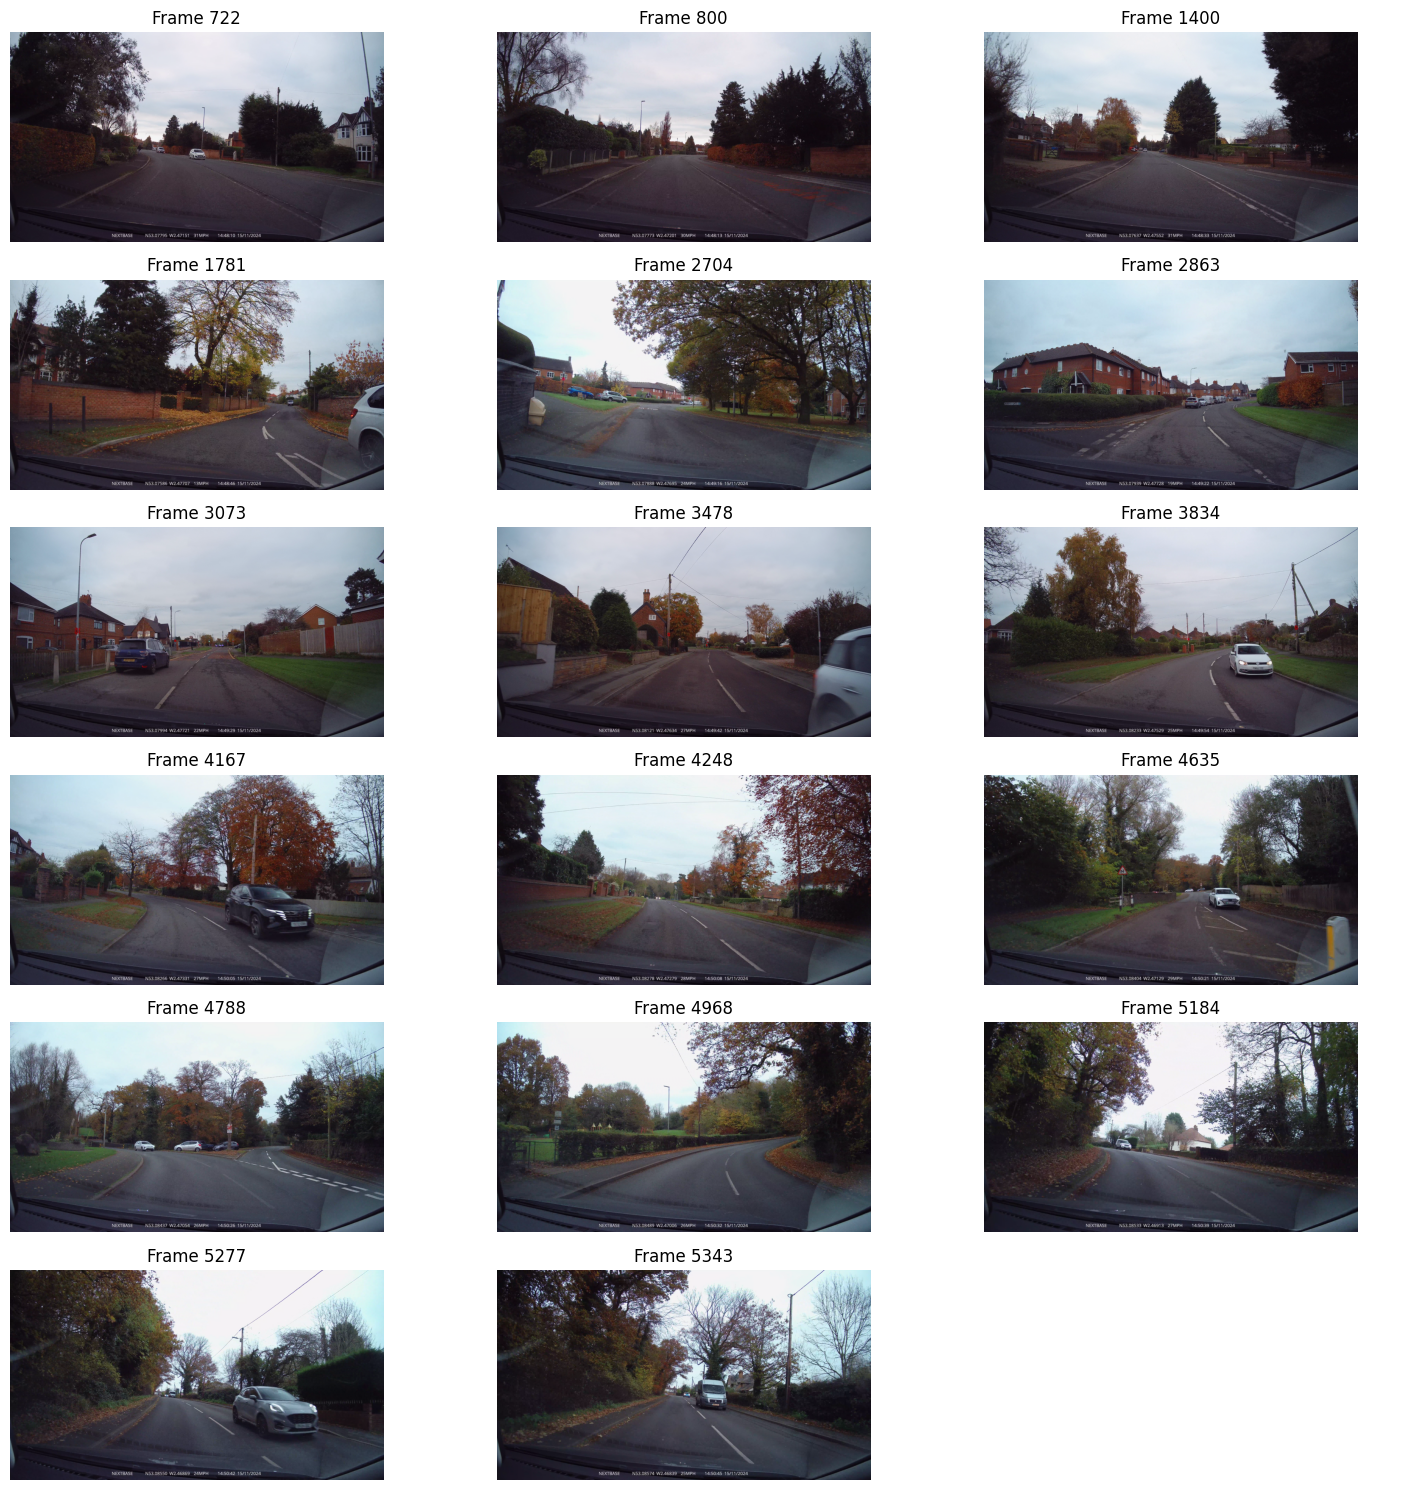

In [32]:
frame_numbers = sorted(frame_numbers)

def print_frames(frame_numbers:list[int], file_path:str = file_path):
    plt.close('all')
    
    frames = []

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame {frame_number}")
    
    cap.release()
    
    if frames:
        n_frames = len(frames)
        n_cols = min(3, n_frames)
        n_rows = math.ceil(n_frames / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")

        for i in range(n_frames, len(axes)): # clear the rest of the axes
            axes[i].axis('off')          

        plt.tight_layout()
    else:
        print("No frames to display")

    return frames

frames = print_frames(frame_numbers)

print(f"Total frames: {total_frames}")

In [33]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)


# Calculate Bends in ROI

In [34]:
def plot_bend(bend_name:str, cluster_center:list[float], points:list[dict], focused_positions:list[dict]=None):
    """Plot the bend with the given name and points

    Args:
        bend_name (str): plot title
        points (list[dict]): list of points
    """
    plt.close('all')
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [float(pos['x']) for pos in points]
    y = [float(pos['y']) for pos in points]
    
    plt.scatter(x, y, s=1)
    plt.scatter(cluster_center[0], cluster_center[1], color='red', s=40)
    if not focused_positions is None:
        focused_x = [float(pos['x']) for pos in focused_positions]
        focused_y = [float(pos['y']) for pos in focused_positions]
        plt.scatter(focused_x, focused_y, color='green', s=40)

    plt.text(
        x[0],
        y[0],
        'Segment Start',
        fontsize=9,
        color='black'
    )

    plt.text(
        x[-1],
        y[-1],
        'Segment End',
        fontsize=9,
        color='black'
    )

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GPS positions near {bend_name}')
    # flip x axis
    plt.gca().invert_xaxis()
    plt.axis('equal')

    plt.savefig(os.path.join(output_folder, f"{bend_name}.png"))

    if args.f:
        plt.show()
    else:
        plt.close('all')

## Find closest position entry to point of interest

In [35]:
def closest_point_to_x_y(x:float, y:float, positions:list[dict]):
    """Get the closest point to x, y

    Args:
        x (float): The x coordinate
        y (float): The y coordinate
        positions (list[dict]): The list of positions

    Returns:
        dict: The closest point
    """
    min_distance = float('inf')
    closest_point = None
    for position in positions:
        distance = np.sqrt((x - position['x'])**2 + (y - position['y'])**2)
        if distance < min_distance:
            min_distance = distance
            closest_point = position
    return closest_point

def get_points_near_a_cluster_estimated_center(
        cluster_center:list[float],
        positions:list[dict],
        distance_threshold:float = 100):
    """Get the points near a cluster estimated center

    Args:
        cluster_center (list[float]): list of estimated centers
        positions (list[dict]): list of gps positions
        distance_threshold (float, optional): The distance threshold. Defaults to 100.

    Returns:
        list[dict]: The positions within the distance threshold
    """
    closest_point = closest_point_to_x_y(cluster_center[0], cluster_center[1], positions)
    closest_point_accumulated_distance = closest_point['distance']
    points = [closest_point]

    print(f"Closest point: {closest_point}")
    print(f"Closest point accumulated distance: {closest_point_accumulated_distance}")

    for position in positions:
        if abs(position['distance'] - closest_point_accumulated_distance) < distance_threshold:
            points.append(position)

    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    return points

## find first curve of a series of points

In [40]:
def find_first_bend_from_series(points:list[dict], min_degree_threshold:float = 2):
    """Find the initial bend from the series of points

    Args:
        points (list[dict]): list of points

    Returns:
        list[float]: The initial bend
    """
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [pos['x'] for pos in points]
    y = [pos['y'] for pos in points]

    angles = get_smoothed_sequence_angles(x, y, meters=7)

    print(angles[:5])

    # set threshold to largest 20% of angles
    abs_angles = np.abs(angles)
    abs_angles = np.sort(abs_angles)
    sum_angles = np.sum(abs_angles)
    auto_degree_threshold = 0
    accumulated_sum = 0
    for i in range(len(abs_angles)):
        accumulated_sum += abs_angles[i]
        if accumulated_sum > sum_angles * 0.7:
            auto_degree_threshold = abs_angles[i]
            break

    print("automatic threshold:", auto_degree_threshold)

    min_degree_threshold = max(min_degree_threshold, auto_degree_threshold)

    first_bend_found = False
    first_bend_sign = None

    tolerance = 3

    first_bend_positions = []
    first_bend_angles_for_direction_label = []

    for i in range(10, len(angles)):
        sign = np.sign(angles[i])
        if abs(angles[i]) > min_degree_threshold:
            if not first_bend_found:
                first_bend_positions.append(points[i])
                first_bend_angles_for_direction_label.append(angles[i])
                first_bend_found = True
                first_bend_sign = sign
            elif first_bend_sign == sign:
                first_bend_positions.append(points[i])
                first_bend_angles_for_direction_label.append(angles[i])
            
            continue

        if first_bend_found and first_bend_sign != sign:
            if tolerance <= 0:
                break
            tolerance -= 1  

    if not first_bend_found or len(first_bend_positions) < 3:
        print("No first bend found")
        return None, None, None

    # determine if the first bend is a left or right bend
    first_bend_sign = np.sign(np.mean(first_bend_angles_for_direction_label))
    average_bend_angle = np.mean(first_bend_angles_for_direction_label)

    print("average steepness on bend:", average_bend_angle)
    
    if first_bend_sign < 0:
        print("First bend is a left bend")
    else:
        print("First bend is a right bend")

    return first_bend_positions, first_bend_sign, average_bend_angle

Closest point: {'time': '144812.600', 'valid': True, 'latitude': 53.07789866666667, 'longitude': -2.4716786666666666, 'height': '40.6', 'speed': 31.68442574, 'x': 353512.0671119724, 'y': 368498.9047407678, 'distance': np.float64(341.0778021940647)}
Closest point accumulated distance: 341.0778021940647
Bend 0: 101 points near the center - Avg Speed: 31.41587242712871 MPH
[-1.10287571 -1.18303081 -1.54066985 -1.72738257 -1.84794883]
automatic threshold: 4.468095232139502
average steepness on bend: -5.284148342200213
First bend is a left bend
Start of focused points: 716


/tmp/ipykernel_30650/494813718.py:54: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)


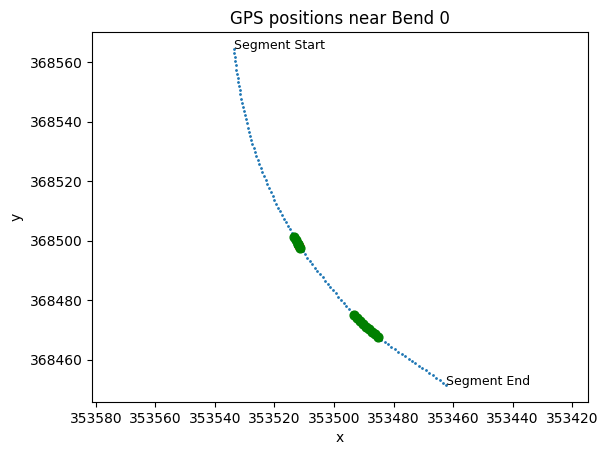

start_of_focused_points_position_accumulated_distance: 338.2644440621547
Closest point: {'time': '144815.200', 'valid': True, 'latitude': 53.077692166666665, 'longitude': -2.4720903333333335, 'height': '42.6', 'speed': 30.72122288, 'x': 353489.27660847595, 'y': 368471.1754248736, 'distance': np.float64(377.03385160149793)}
Closest point accumulated distance: 377.03385160149793
Bend 1: 100 points near the center - Avg Speed: 31.526435153799998 MPH
[-2.48053813 -2.60839898 -2.71518137 -2.64970668 -2.53625919]
automatic threshold: 4.490939391304492
average steepness on bend: -5.3868859903492154
First bend is a left bend
Start of focused points: 719


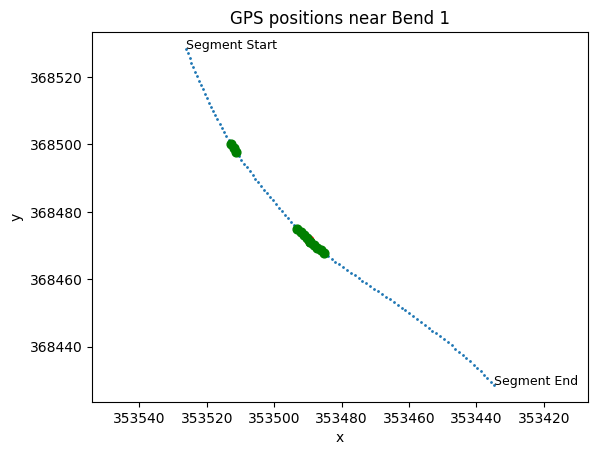

start_of_focused_points_position_accumulated_distance: 339.66105452716715
Closest point: {'time': '144835.200', 'valid': True, 'latitude': 53.0763475, 'longitude': -2.475624, 'height': '44.3', 'speed': 32.49342408, 'x': 353341.25464731856, 'y': 368233.45761802833, 'distance': np.float64(664.4502322518978)}
Closest point accumulated distance: 664.4502322518978
Bend 2: 104 points near the center - Avg Speed: 30.37086569596154 MPH
[1.5822836  1.25709058 0.81077018 0.77758077 0.73536341]
automatic threshold: 2.8837064660518434
average steepness on bend: -4.5995793302630075
First bend is a left bend
Start of focused points: 1394


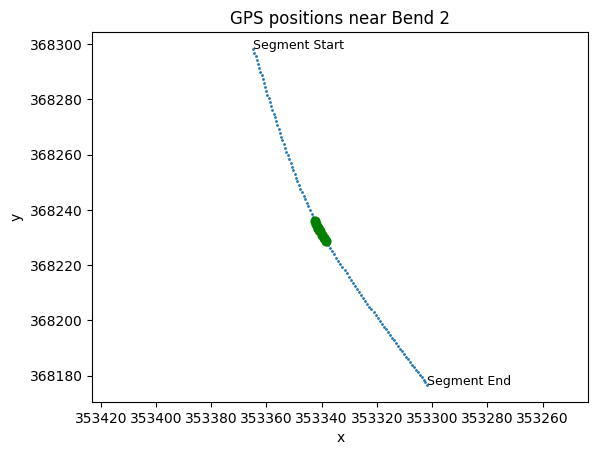

start_of_focused_points_position_accumulated_distance: 661.5571013849257
Closest point: {'time': '144847.900', 'valid': True, 'latitude': 53.07587133333333, 'longitude': -2.4770841666666668, 'height': '43.3', 'speed': 14.622961459999999, 'x': 353288.9338307462, 'y': 368135.2834708231, 'distance': np.float64(786.859443137071)}
Closest point accumulated distance: 786.859443137071
Bend 3: 166 points near the center - Avg Speed: 19.01159963819277 MPH
[-0.87122413 -0.72493373 -0.74250299 -0.93332063 -0.95834339]
automatic threshold: 44.78604184434156
average steepness on bend: 46.02394229775623
First bend is a right bend
Start of focused points: 1712


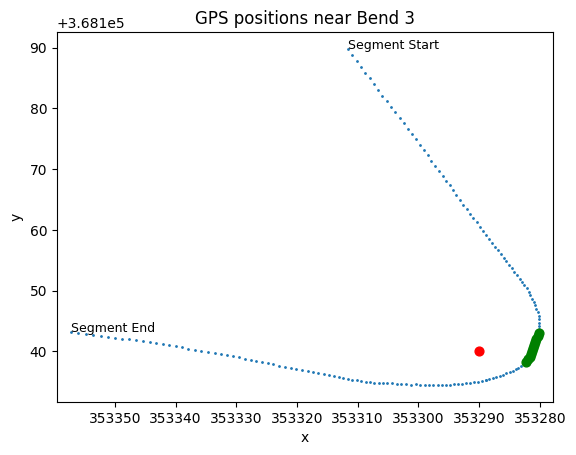

start_of_focused_points_position_accumulated_distance: 774.1968560882109
Closest point: {'time': '144918.700', 'valid': True, 'latitude': 53.07897766666667, 'longitude': -2.4769579999999998, 'height': '44.2', 'speed': 22.93619618, 'x': 353634.44293793984, 'y': 368146.0369291725, 'distance': np.float64(1134.019021031603)}
Closest point accumulated distance: 1134.019021031603
Bend 4: 139 points near the center - Avg Speed: 22.7023063542446 MPH
[0.61431424 0.69985019 0.72669708 0.798767   0.95749123]
automatic threshold: 9.221001755996696
average steepness on bend: -15.949164714350266
First bend is a left bend
Start of focused points: 2689


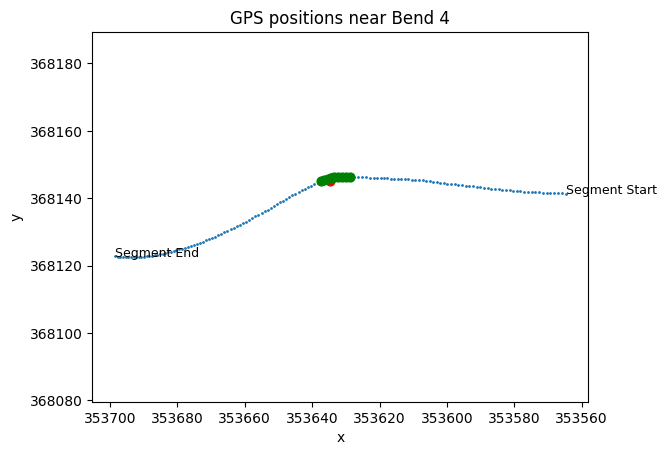

start_of_focused_points_position_accumulated_distance: 1128.3072669212413
Closest point: {'time': '144924.000', 'valid': True, 'latitude': 53.079410833333334, 'longitude': -2.4772928333333333, 'height': '43.2', 'speed': 18.85898264, 'x': 353682.7801785151, 'y': 368123.92782347417, 'distance': np.float64(1187.3623640628134)}
Closest point accumulated distance: 1187.3623640628134
Bend 5: 146 points near the center - Avg Speed: 21.556095677808216 MPH
[ 0.68994009  0.11583249 -0.64168805 -1.23864582 -1.67921742]
automatic threshold: 8.808588727331772
average steepness on bend: -15.35630657085266
First bend is a left bend
Start of focused points: 2692


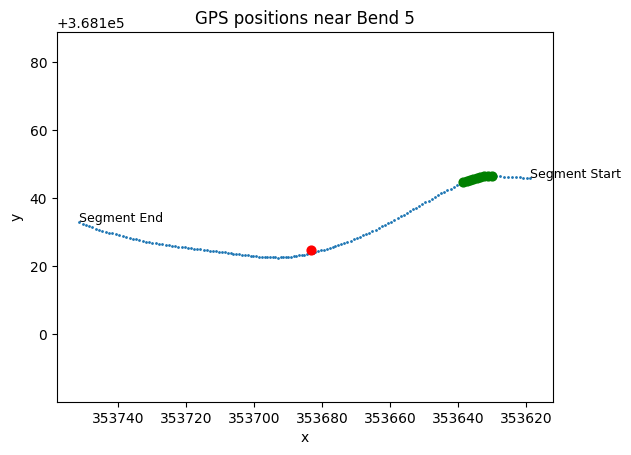

start_of_focused_points_position_accumulated_distance: 1129.5125045200448
Closest point: {'time': '144931.000', 'valid': True, 'latitude': 53.07996816666667, 'longitude': -2.4772023333333335, 'height': '42.3', 'speed': 22.93274384, 'x': 353744.74059520994, 'y': 368130.40335771523, 'distance': np.float64(1250.160459207306)}
Closest point accumulated distance: 1250.160459207306
Bend 6: 141 points near the center - Avg Speed: 22.359606430638294 MPH
[3.73259883 3.85666905 4.28374713 4.56385465 4.7354674 ]
automatic threshold: 6.875702963624817
average steepness on bend: 8.307099959337823
First bend is a right bend
Start of focused points: 2872


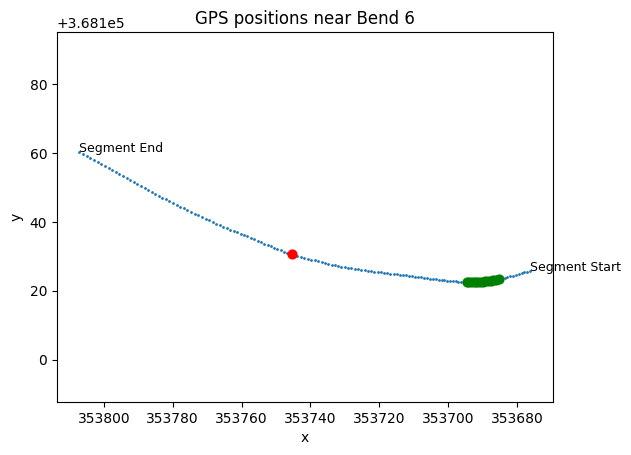

start_of_focused_points_position_accumulated_distance: 1189.8392864788632
Closest point: {'time': '144944.500', 'valid': True, 'latitude': 53.08129266666667, 'longitude': -2.4762866666666667, 'height': '42.4', 'speed': 24.874109699999995, 'x': 353891.6769841739, 'y': 368192.7215098999, 'distance': np.float64(1410.2590000820894)}
Closest point accumulated distance: 1410.2590000820894
Bend 7: 116 points near the center - Avg Speed: 27.176830400517236 MPH
[-0.85670124 -0.76221609 -0.82065523 -1.13989448 -1.55851357]
automatic threshold: 3.454372197287171
No first bend found


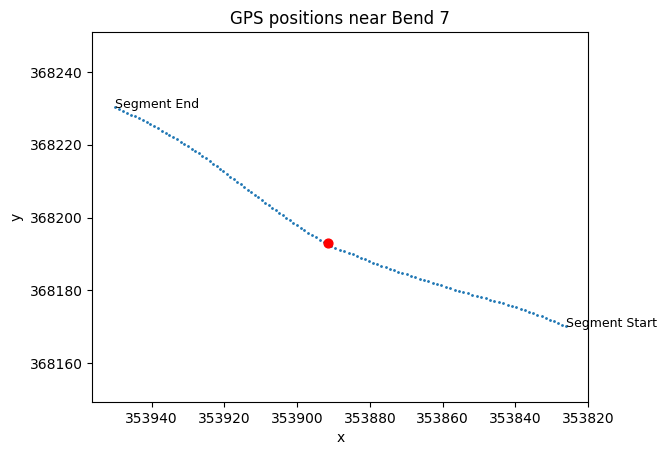

Closest point: {'time': '144956.400', 'valid': True, 'latitude': 53.082392166666665, 'longitude': -2.4752183333333333, 'height': '37.2', 'speed': 25.98691396, 'x': 354013.5160939108, 'y': 368265.0959948308, 'distance': np.float64(1552.709776029301)}
Closest point accumulated distance: 1552.709776029301
Bend 8: 114 points near the center - Avg Speed: 27.65332415649122 MPH
[ 0.64604618 -0.20125535 -1.20126441 -1.90016336 -2.01866076]
automatic threshold: 11.039077726582645
average steepness on bend: 16.341284515165373
First bend is a right bend
Start of focused points: 3873


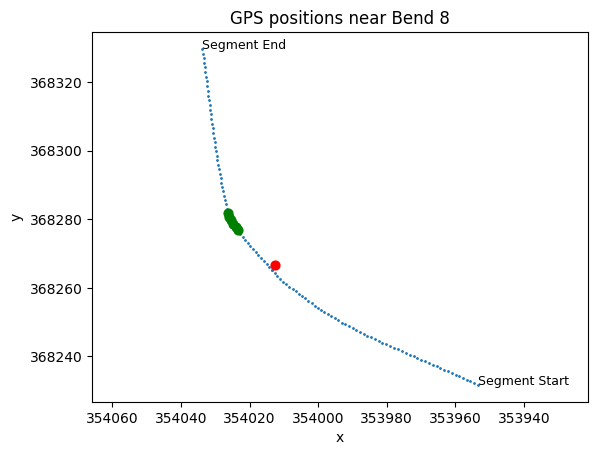

start_of_focused_points_position_accumulated_distance: 1568.0204865001488
Closest point: {'time': '145007.500', 'valid': True, 'latitude': 53.082685166666664, 'longitude': -2.4731725, 'height': '37.8', 'speed': 27.965104779999997, 'x': 354045.2037555356, 'y': 368402.3492037547, 'distance': np.float64(1695.9523281034135)}
Closest point accumulated distance: 1695.9523281034135
Bend 9: 110 points near the center - Avg Speed: 28.73603322527272 MPH
[0.17517586 0.27746933 0.28592547 0.12706021 0.12301412]
automatic threshold: 6.379211799283238
average steepness on bend: -7.737533084991651
First bend is a left bend
Start of focused points: 4224


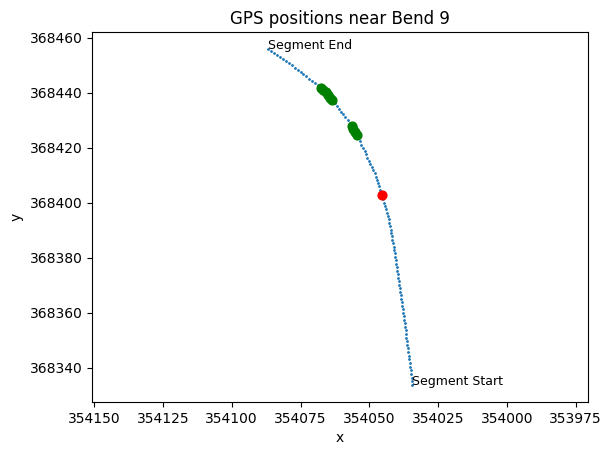

start_of_focused_points_position_accumulated_distance: 1720.0953725750483
Closest point: {'time': '145010.200', 'valid': True, 'latitude': 53.082822166666666, 'longitude': -2.4727145, 'height': '36.4', 'speed': 28.56926428, 'x': 354060.24181946495, 'y': 368433.12820705306, 'distance': np.float64(1730.392454990905)}
Closest point accumulated distance: 1730.392454990905
Bend 10: 110 points near the center - Avg Speed: 28.68601614181818 MPH
[-0.13256167 -0.09358548  0.03056645 -0.06059815 -0.22448292]
automatic threshold: 6.380138840695659
average steepness on bend: -7.746412452778202
First bend is a left bend
Start of focused points: 4224


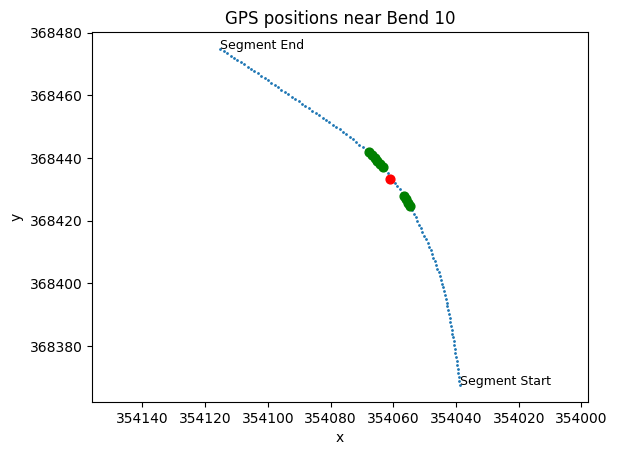

start_of_focused_points_position_accumulated_distance: 1720.0953725750483
Closest point: {'time': '145023.100', 'valid': True, 'latitude': 53.0840765, 'longitude': -2.4712406666666666, 'height': '30.8', 'speed': 28.976640399999997, 'x': 354199.13029207825, 'y': 368532.7684222919, 'distance': np.float64(1902.0209773300346)}
Closest point accumulated distance: 1902.0209773300346
Bend 11: 110 points near the center - Avg Speed: 28.721481089090908 MPH
[0.40216636 0.26506572 0.14708222 0.25146357 0.35253925]
automatic threshold: 3.425692251922861
average steepness on bend: 3.73498570867876
First bend is a right bend
Start of focused points: 4626


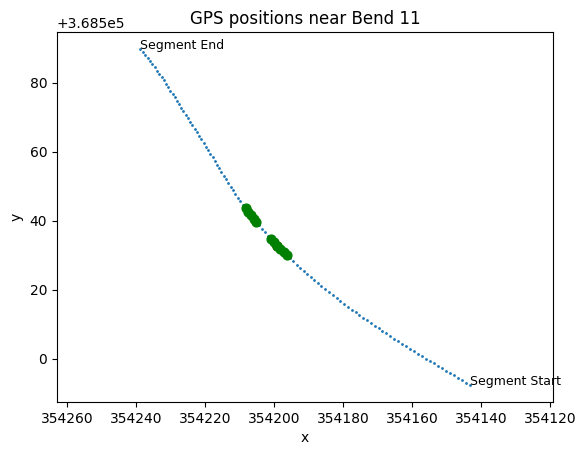

start_of_focused_points_position_accumulated_distance: 1898.0568150616382
Closest point: {'time': '145028.200', 'valid': True, 'latitude': 53.08439833333333, 'longitude': -2.4704728333333335, 'height': '30.7', 'speed': 25.56112536, 'x': 354234.59471518855, 'y': 368584.4340671523, 'distance': np.float64(1964.8035984214375)}
Closest point accumulated distance: 1964.8035984214375
Bend 12: 117 points near the center - Avg Speed: 26.925655368205128 MPH
[1.81599362 2.50147437 3.15117309 3.57179079 3.88965584]
automatic threshold: 10.217404847878514
average steepness on bend: -14.024107089518438
First bend is a left bend
Start of focused points: 4836


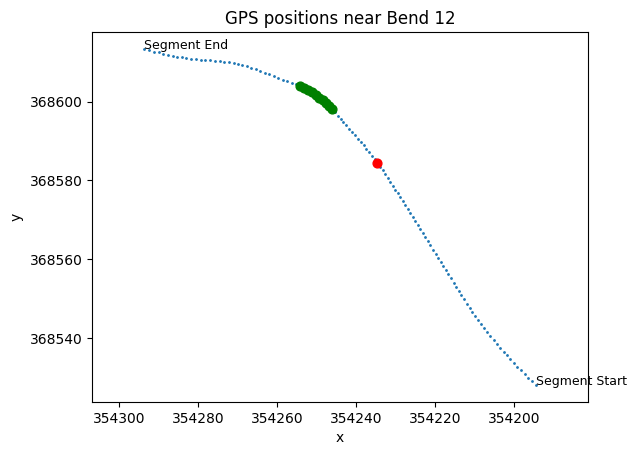

start_of_focused_points_position_accumulated_distance: 1982.5513143775174
Closest point: {'time': '145034.200', 'valid': True, 'latitude': 53.084942166666664, 'longitude': -2.4700423333333332, 'height': '30.4', 'speed': 28.5048206, 'x': 354294.9044510776, 'y': 368613.666345482, 'distance': np.float64(2034.8207870142833)}
Closest point accumulated distance: 2034.8207870142833
Bend 13: 117 points near the center - Avg Speed: 26.83406508307692 MPH
[-2.94298613 -3.19805165 -3.53281467 -3.28721818 -2.65740009]
automatic threshold: 10.958032614069008
average steepness on bend: -14.364782031235043
First bend is a left bend
Start of focused points: 4836


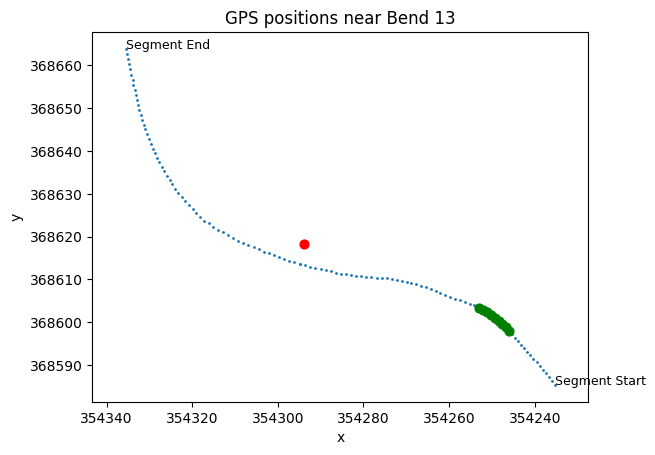

start_of_focused_points_position_accumulated_distance: 1982.5513143775174
Closest point: {'time': '145041.400', 'valid': True, 'latitude': 53.08535533333333, 'longitude': -2.4690115, 'height': '34.6', 'speed': 27.04448078, 'x': 354340.41478752013, 'y': 368683.0124952431, 'distance': np.float64(2124.234513695122)}
Closest point accumulated distance: 2124.234513695122
Bend 14: 120 points near the center - Avg Speed: 26.314416358166667 MPH
[11.44098134 11.8796768  12.51041172 13.38117693 13.03352029]
automatic threshold: 10.718010615784754
average steepness on bend: -14.679301025021575
First bend is a left bend
Start of focused points: 5190


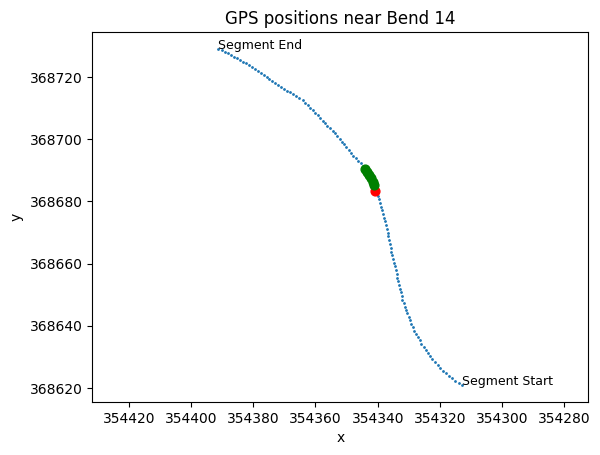

start_of_focused_points_position_accumulated_distance: 2126.6096045126005
Closest point: {'time': '145044.500', 'valid': True, 'latitude': 53.0855555, 'longitude': -2.4685981666666668, 'height': '35.5', 'speed': 25.525451179999997, 'x': 354362.501236113, 'y': 368710.8429675606, 'distance': np.float64(2160.1049058325393)}
Closest point accumulated distance: 2160.1049058325393
Bend 15: 101 points near the center - Avg Speed: 25.880711778019798 MPH
[0.09558979 0.97819755 0.61302119 0.53756241 0.35757135]
automatic threshold: 10.665517217956896
average steepness on bend: -14.58623551105939
First bend is a left bend
Start of focused points: 5190


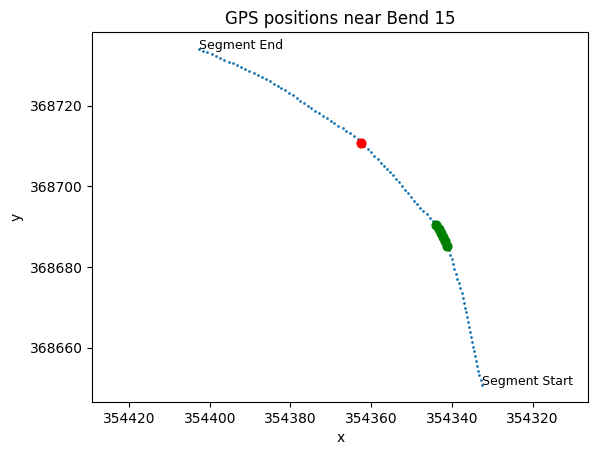

start_of_focused_points_position_accumulated_distance: 2126.6096045126005
Closest point: {'time': '145046.700', 'valid': True, 'latitude': 53.0857425, 'longitude': -2.4683905, 'height': '35.9', 'speed': 25.11462272, 'x': 354383.21318177023, 'y': 368724.88832198357, 'distance': np.float64(2185.18956011728)}
Closest point accumulated distance: 2185.18956011728
Bend 16: 81 points near the center - Avg Speed: 25.62958966641975 MPH
[-0.65636434 -0.26224292 -0.8604125  -1.92165481 -2.68501375]
automatic threshold: 10.819893737648437
average steepness on bend: -14.941987092101693
First bend is a left bend
Start of focused points: 5193


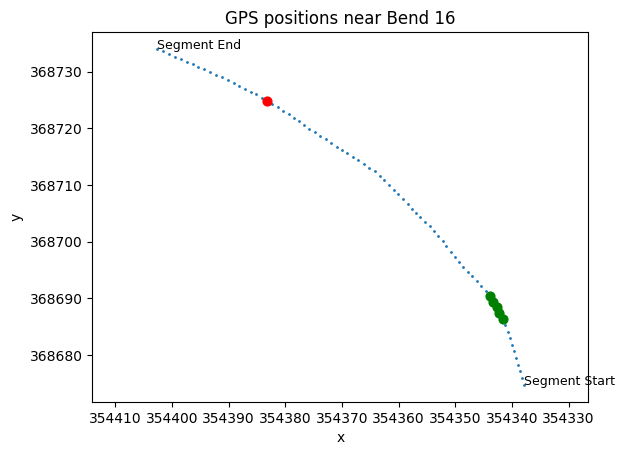

start_of_focused_points_position_accumulated_distance: 2127.7734065676013


In [41]:
bends_for_curve_fitting = []

for i, bend in enumerate(cluster_centers):
    records = get_points_near_a_cluster_estimated_center(bend, positions, distance_threshold=70)
    avg_speed = np.mean([float(pos['speed']) for pos in records])
    print(f"Bend {i}: {len(records)} points near the center - Avg Speed: {avg_speed} MPH")

    focused_points, first_bend_sign, average_bend_angle = find_first_bend_from_series(records, min_degree_threshold=2)

    if focused_points is not None:
        start_of_focused_points = focused_points[0]
        start_of_focused_points_frame = time_stamp_to_frame_number(start_of_focused_points['time'])
        print(f"Start of focused points: {start_of_focused_points_frame}")

    plot_bend(f"Bend {i}", bend, records, focused_points)

    if len(records) > 0 and focused_points is not None:
        start_of_focused_points = focused_points[0]
        print(f"start_of_focused_points_position_accumulated_distance: {start_of_focused_points['distance']}")

        bends_for_curve_fitting.append({
            "bend": bend,
            "focused_points": focused_points,
            "Estimated_start_frame": start_of_focused_points_frame,
            "first_bend_sign": "Left" if first_bend_sign < 0 else "Right",
            "average_bend_angle": average_bend_angle,
            "avg_speed": avg_speed,
            "start_of_focused_points_position_accumulated_distance": start_of_focused_points['distance']
        })

# Kasa Iterative Curve Fitting

In [107]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import least_squares

# class Circle:
#     def __init__(self, a, b, r, s, j):
#         self.a = a  # X-coordinate of the center
#         self.b = b  # Y-coordinate of the center
#         self.r = r  # Radius
#         self.s = s  # Root mean square error
#         self.j = j  # Total number of iterations

# class Data:
#     def __init__(self, X, Y):
#         self.X = np.array(X)
#         self.Y = np.array(Y)
#         self.n = len(X)

# def geometric_distance(params, X, Y):
#     a, b, r = params
#     return np.sqrt((X - a)**2 + (Y - b)**2) - r

# def Sigma(data, circle):
#     # Compute the root mean square error (estimate of sigma)
#     distances = np.sqrt((data.X - circle.a)**2 + (data.Y - circle.b)**2)
#     sigma = np.sqrt(np.mean((distances - circle.r)**2))
#     return sigma

# def CircleFitIterative(data, initial_guess=None, max_iterations=100, tol=1e-9):
#     if initial_guess is None:
#         # Use the Kasa method to obtain an initial guess
#         initial_guess = CircleFitByKasa(data)
#         initial_params = [initial_guess.a, initial_guess.b, initial_guess.r]
#     else:
#         initial_params = initial_guess

#     # Perform the iterative fitting using Levenberg–Marquardt algorithm
#     result = least_squares(geometric_distance, initial_params, args=(data.X, data.Y), max_nfev=max_iterations, ftol=tol, xtol=tol, gtol=tol)

#     # Extract the optimized parameters
#     a, b, r = result.x
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = result.nfev  # Number of function evaluations

#     return Circle(a, b, r, s, j)

# def CircleFitByKasa(data):
#     # Center the data points
#     Xi = data.X - np.mean(data.X)
#     Yi = data.Y - np.mean(data.Y)
#     Zi = Xi**2 + Yi**2

#     # Compute moments
#     Mxx = np.mean(Xi**2)
#     Myy = np.mean(Yi**2)
#     Mxy = np.mean(Xi * Yi)
#     Mxz = np.mean(Xi * Zi)
#     Myz = np.mean(Yi * Zi)

#     # Solve the system of equations using Cholesky factorization
#     G11 = np.sqrt(Mxx)
#     G12 = Mxy / G11
#     G22 = np.sqrt(Myy - G12**2)

#     D1 = Mxz / G11
#     D2 = (Myz - D1 * G12) / G22

#     # Compute parameters of the fitting circle
#     C = D2 / G22 / 2
#     B = (D1 - G12 * C) / G11 / 2

#     # Assemble the output
#     a = B + np.mean(data.X)
#     b = C + np.mean(data.Y)
#     r = np.sqrt(B**2 + C**2 + Mxx + Myy)
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = 0  # Number of iterations (not applicable for Kasa's method)

#     return Circle(a, b, r, s, j)

# f_bend = bends_for_curve_fitting[1]['points']
# order_by_time = sorted(f_bend, key=lambda x: time_stamp_to_seconds(x['time']))
# X = [float(pos['x']) for pos in order_by_time]
# Y = [float(pos['y']) for pos in order_by_time]

# diff_x = np.diff(X)
# diff_y = np.diff(Y)
# angles = np.arctan2(diff_x, diff_y)
# angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles
# angles = np.degrees(angles)

# angles = np.diff(angles)

# # smooth angles with gaussian filter
# angles = np.convolve(angles, np.ones(3) / 3, mode='same')


# # apply median filter
# angles = apply_median_filter(angles, 10)

# # plot angles
# plt.plot(angles)
# plt.show()

# min_degree = 0.5

# print(f"Found {len(X)} points before filtering")
# print(angles[:10])

# angle_threshold_mask = [np.abs(angles) > min_degree]
# print(angle_threshold_mask[:10])

# X_a = np.array(X[1:-1])[np.abs(angles) > min_degree]
# Y_a = np.array(Y[1:-1])[np.abs(angles) > min_degree]

# # # ignore after sign change
# # angles_temp = angles[np.abs(angles) > min_degree]
# # angle_sign = np.sign(angles_temp)
# # initial_angle = angle_sign[1]

# # X_a = []
# # Y_a = []

# # for i in range(1, min(len(X)-1, len(angles))):
# #     if np.abs(angles[i-1]) > min_degree:
# #         if not (angle_sign[i-1] != initial_angle):
# #             break
# #         X_a.append(X[i])
# #         Y_a.append(Y[i])


# print(f"Found {len(X_a)} points after filtering")

# data = Data(X_a,Y_a)
# fitted_circle = CircleFitIterative(data)


# print(f"Center: ({fitted_circle.a}, {fitted_circle.b})")
# print(f"Radius: {fitted_circle.r}")
# print(f"RMS Error: {fitted_circle.s}")
# print(f"Iterations: {fitted_circle.j}")

# plt.scatter(X, Y)
# plt.scatter(fitted_circle.a, fitted_circle.b, color='red')
# plt.scatter(X_a, Y_a, color='green')
# plt.text(
#     X[0],
#     Y[0],
#     'Segment Start',
#     fontsize=9,
#     color='black'
# )

# plt.text(
#     X[-1],
#     Y[-1],
#     'Segment End',
#     fontsize=9,
#     color='black'
# )

# circle = plt.Circle((fitted_circle.a, fitted_circle.b), fitted_circle.r, color='r', fill=False)

# plt.gca().add_artist(circle)
# plt.axis('equal')
# plt.show()


# Organise and Filter CSV

In [42]:
columns = ["frame", "bend_direction", "avg_speed", "start_of_focused_points_position_accumulated_distance", "average_bend_angle"]
data = []

for bend in bends_for_curve_fitting:
    data.append([bend['Estimated_start_frame'], bend['first_bend_sign'],bend['avg_speed'], bend['start_of_focused_points_position_accumulated_distance'], bend['average_bend_angle']])

df = pd.DataFrame(data, columns=columns)

df

frame bend_direction  avg_speed  \
0     716           Left  31.415872   
1     719           Left  31.526435   
2    1394           Left  30.370866   
3    1712          Right  19.011600   
4    2689           Left  22.702306   
5    2692           Left  21.556096   
6    2872          Right  22.359606   
7    3873          Right  27.653324   
8    4224           Left  28.736033   
9    4224           Left  28.686016   
10   4626          Right  28.721481   
11   4836           Left  26.925655   
12   4836           Left  26.834065   
13   5190           Left  26.314416   
14   5190           Left  25.880712   
15   5193           Left  25.629590   

    start_of_focused_points_position_accumulated_distance  average_bend_angle  
0                                          338.264444               -5.284148  
1                                          339.661055               -5.386886  
2                                          661.557101               -4.599579  
3                                          774.196856               46.023942  
4                                         1128.307267              -15.949165  
5                                         1129.512505              -15.356307  
6                                         1189.839286                8.307100  
7                                         1568.020487               16.341285  
8                                         1720.095373               -7.737533  
9                                         1720.095373               -7.746412  
10                                        1898.056815                3.734986  
11                                        1982.551314              -14.024107  
12                                        1982.551314              -14.364782  
13                                        2126.609605              -14.679301  
14                                        2126.609605              -14.586236  
15                                        2127.773407              -14.941987

In [43]:
def select_first_of_nearby_frames(df, min_accumulated_dist = 30):
    """Select the first frame of nearby frames

    Args:
        df (pd.DataFrame): The dataframe
        min_accumulated_dist (int, optional): The minimum distance. Defaults to 100.

    Returns:
        pd.DataFrame: The selected dataframe
    """
    selected = []
    for i in range(len(df)):
        if i == 0:
            selected.append(df.iloc[i])
            continue

        if df.iloc[i]['start_of_focused_points_position_accumulated_distance'] - selected[-1]['start_of_focused_points_position_accumulated_distance'] > min_accumulated_dist:
            selected.append(df.iloc[i])

    return pd.DataFrame(selected)

In [44]:
df = select_first_of_nearby_frames(df)
df

frame bend_direction  avg_speed  \
0     716           Left  31.415872   
2    1394           Left  30.370866   
3    1712          Right  19.011600   
4    2689           Left  22.702306   
6    2872          Right  22.359606   
7    3873          Right  27.653324   
8    4224           Left  28.736033   
10   4626          Right  28.721481   
11   4836           Left  26.925655   
13   5190           Left  26.314416   

    start_of_focused_points_position_accumulated_distance  average_bend_angle  
0                                          338.264444               -5.284148  
2                                          661.557101               -4.599579  
3                                          774.196856               46.023942  
4                                         1128.307267              -15.949165  
6                                         1189.839286                8.307100  
7                                         1568.020487               16.341285  
8                                         1720.095373               -7.737533  
10                                        1898.056815                3.734986  
11                                        1982.551314              -14.024107  
13                                        2126.609605              -14.679301

### Visualise

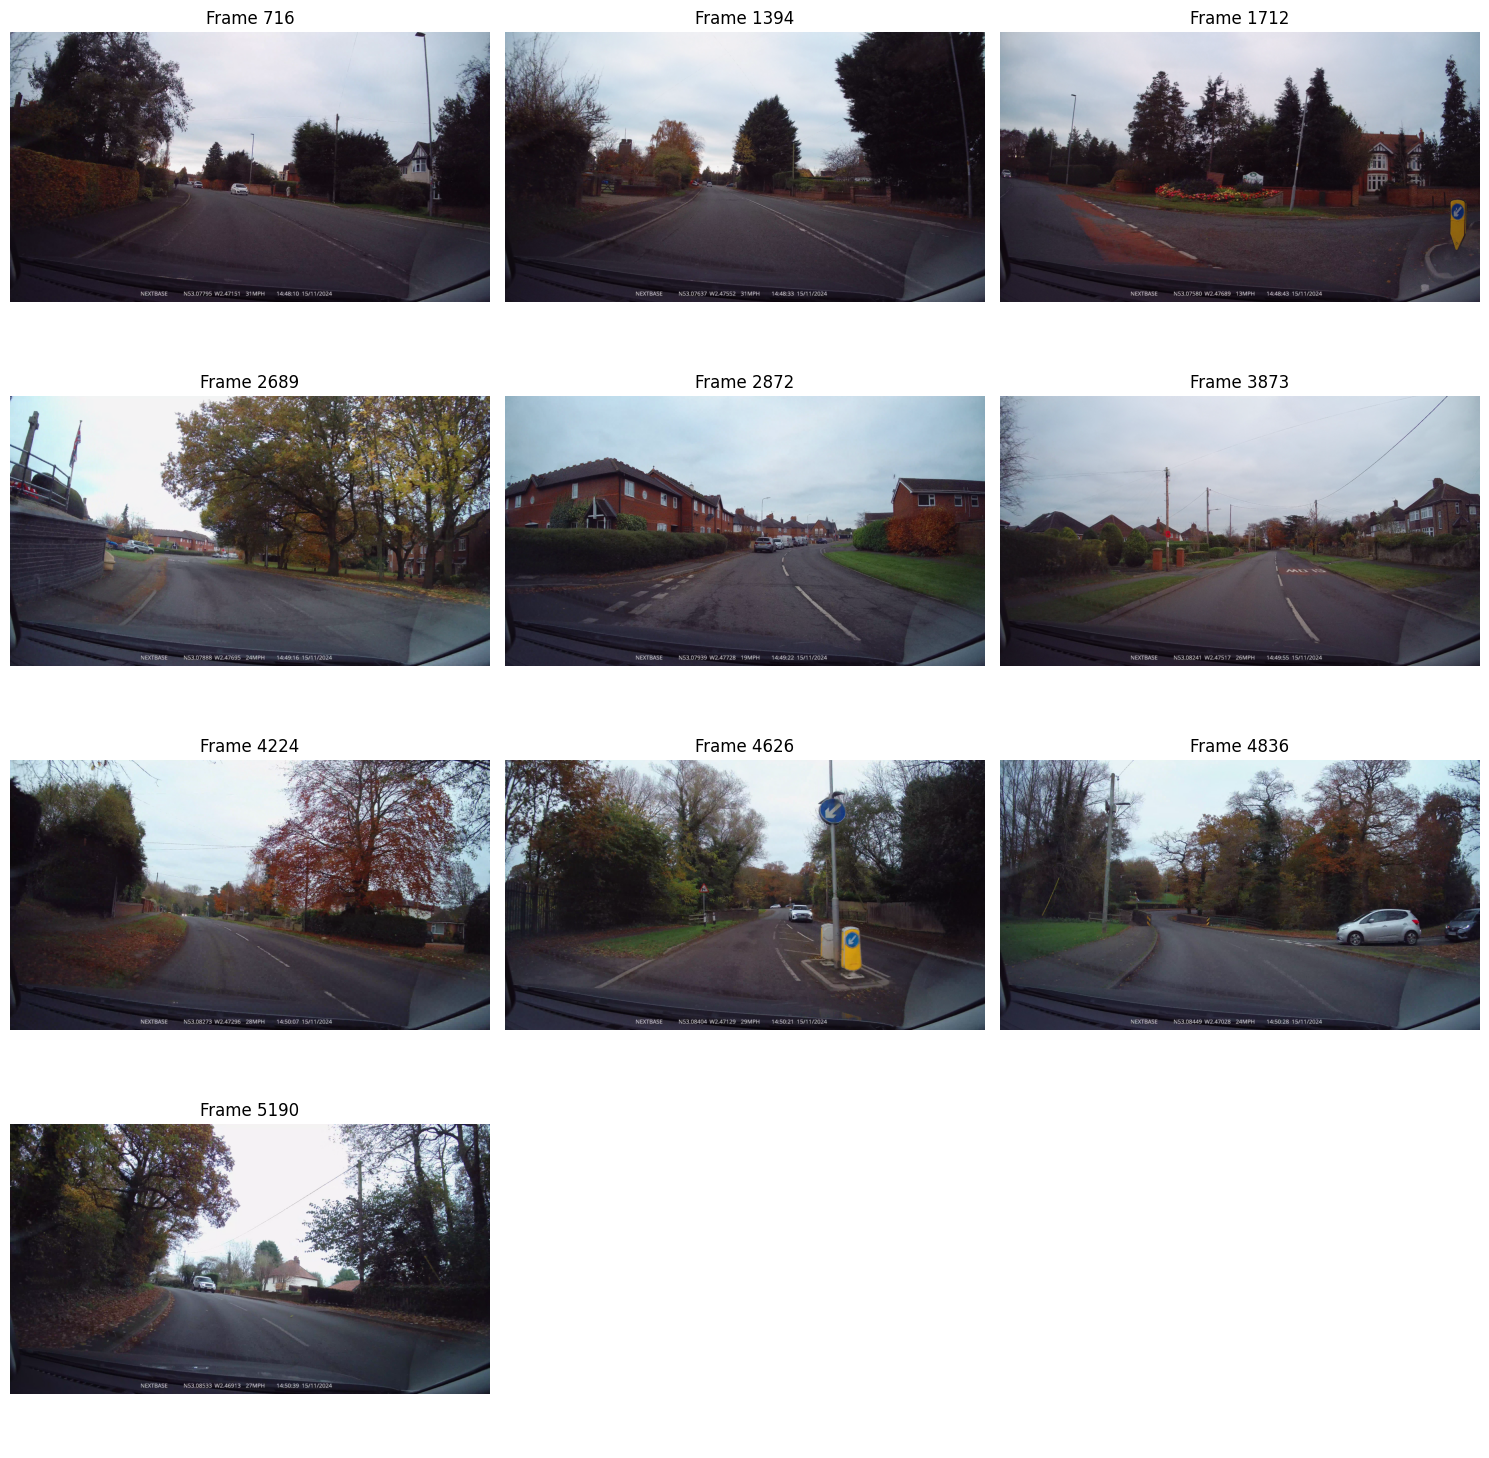

In [45]:
if bends_for_curve_fitting:
	frames = print_frames(df['frame'].tolist())
	for i, frame in enumerate(frames):
		df_row = df.iloc[i]
		output_file = os.path.join(output_folder, f"bend_{i}_frame_{df_row['frame']}_{df_row['bend_direction']}_speed_{int(df_row['avg_speed'])}_angle_{int(df_row['average_bend_angle'])}.jpg")
		cv2.imwrite(output_file, frame)
else:
	print("No bends found for curve fitting.")
	


## Get frame number of x meters before start of bend

In [112]:
accumulated_position_distance = [pos['distance'] for pos in positions]

In [118]:
def find_frame_nearest_point_to_given_accumulated_distance(positions:list[float], distance:float):
    """Find the nearest point to a given accumulated distance

    Args:
        positions (list[float]): The list of positions
        distance (float): target distance
    """

    min_distance = float('inf')
    nearest_point = None

    for pos in positions:
        if abs(pos['distance'] - distance) < min_distance:
            min_distance = abs(pos['distance'] - distance)
            nearest_point = pos

    time = nearest_point['time']
    frame = time_stamp_to_frame_number(time)

    return frame


columns = [
    "frame",
    "bend_direction",
    "avg_speed",
    "average_bend_angle",
    "start_of_focused_points_position_accumulated_distance",
    "frame_20_meters_before",
    "frame_30_meters_before",
    "frame_40_meters_before",
    "frame_50_meters_before",
    "frame_75_meters_before",
    "frame_100_meters_before",
    "frame_150_meters_before"
    ]


data_val = []

for i in range(len(df)):
    df_row = df.iloc[i]
    bend_accumulated_distance = df_row['start_of_focused_points_position_accumulated_distance']

    frame_20_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 20)
    frame_30_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 30)
    frame_40_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 40)
    frame_50_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 50)
    frame_75_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 75)
    frame_100_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 100)
    frame_150_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 150)

    data_val.append([
        df_row['frame'],
        df_row['bend_direction'],
        df_row['avg_speed'],
        df_row['average_bend_angle'],
        df_row['start_of_focused_points_position_accumulated_distance'],
        frame_20_meters_before,
        frame_30_meters_before,
        frame_40_meters_before,
        frame_50_meters_before,
        frame_75_meters_before,
        frame_100_meters_before,
        frame_150_meters_before
    ])


df_with_accumulated_distance = pd.DataFrame(data_val, columns=columns)
df_with_accumulated_distance

frame bend_direction  avg_speed  average_bend_angle  \
0     563           Left  31.453393           -3.323779   
1     650           Left  31.672427           -3.445466   
2    1394           Left  28.521587           -3.694837   
3    1694          Right  21.143569           33.610434   
4    2689           Left  22.689075          -12.080245   
5    2860          Right  22.980357            5.673584   
6    3304           Left  27.079212           -3.034853   
7    3819          Right  27.766434           10.620649   
8    4155           Left  29.069468           -4.869098   
9    4830           Left  28.296233           -9.909409   
10   5016          Right  26.536628            8.237390   
11   5187           Left  25.890205          -11.356887   

    start_of_focused_points_position_accumulated_distance  \
0                                          265.813339       
1                                          306.962741       
2                                          661.557101       
3                                          770.851943       
4                                         1128.307267       
5                                         1186.519416       
6                                         1338.541129       
7                                         1546.904583       
8                                         1690.959226       
9                                         1980.375335       
10                                        2055.597617       
11                                        2125.421438       

    frame_20_meters_before  frame_30_meters_before  frame_40_meters_before  \
0                      521                     497                     476   
1                      608                     587                     566   
2                     1352                    1331                    1310   
3                     1613                    1583                    1553   
4                     2632                    2605                    2578   
5                     2797                    2767                    2740   
6                     3253                    3229                    3205   
7                     3768                    3741                    3717   
8                     4107                    4083                    4062   
9                     4776                    4752                    4725   
10                    4971                    4947                    4920   
11                    5139                    5115                    5088   

    frame_50_meters_before  frame_75_meters_before  frame_100_meters_before  \
0                      455                     401                      350   
1                      545                     491                      437   
2                     1289                    1238                     1187   
3                     1529                    1469                     1415   
4                     2551                    2485                     2422   
5                     2710                    2644                     2572   
6                     3178                    3112                     3040   
7                     3693                    3630                     3568   
8                     4038                    3981                     3927   
9                     4701                    4644                     4587   
10                    4896                    4830                     4764   
11                    5064                    5004                     4944   

    frame_150_meters_before  
0                       248  
1                       332  
2                      1082  
3                      1310  
4                      2296  
5                      2443  
6                      2866  
7                      3445  
8                      3804  
9                      4476  
10                     4644  
11                     4815

In [114]:
csv_save_path = os.path.join(output_folder, "bend_directions.csv")
df_with_accumulated_distance.to_csv(csv_save_path, index=False)
print(f"Saved bend directions to {csv_save_path}")

Saved bend directions to /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/bend_directions.csv


In [115]:
def resize_frame_to_224(frame):
    """Resize the frame to 224x224

    Args:
        frame (np.ndarray): The frame

    Returns:
        np.ndarray: The resized frame
    """
    # crop 20% off left and right
    frame = frame[:, int(frame.shape[1] * 0.2):int(frame.shape[1] * 0.8)]

    # crop 25% off top and bottom 
    frame = frame[int(frame.shape[0] * 0.25):int(frame.shape[0] * 0.75), :]

    return cv2.resize(frame, (224, 224))

In [116]:
MIN_FRAME = 0
MAX_FRAME = total_frames
video_frame_length = 60

def save_avi_from_to(path, from_frame, to_frame):
    """Save a video from a given frame to another

    Args:
        path (str): The path to the video
        from_frame (int): The starting frame
        to_frame (int): The ending frame
    """

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

    sample_frame = cap.read()[1]

    sample_frame = resize_frame_to_224(sample_frame)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(f"image shape: {sample_frame.shape}")

    out = cv2.VideoWriter(path, fourcc, 15.0, (int(sample_frame.shape[1]), int(sample_frame.shape[0])))

    cap.set(cv2.CAP_PROP_POS_FRAMES, from_frame)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = resize_frame_to_224(frame)
            out.write(frame)
        else:
            break

        ret, frame = cap.read() # skip a frame

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= to_frame:
            break

    cap.release()
    out.release()

In [ ]:
# create vid_samples folder id not exists
samples_output_folder = os.path.join(output_folder, "vid_samples")
if not os.path.exists(samples_output_folder):
    os.makedirs(samples_output_folder)

samples_output_folder = os.path.join(samples_output_folder, "RGB")
if not os.path.exists(samples_output_folder):
    os.makedirs(samples_output_folder)

last_bend_frame = None

for i in range(len(df_with_accumulated_distance)):
    df_row = df_with_accumulated_distance.iloc[i]

    bend_frame = df_row['frame']

    distance_columns = [col for col in df_with_accumulated_distance.columns if '_meters_before' in col]

    direction = df_row['bend_direction']
    speed = int(df_row['avg_speed'])
    accumulated_distance = df_row['start_of_focused_points_position_accumulated_distance']
    avg_angle = int(df_row['average_bend_angle'])

    for distance_column in distance_columns:
        distance = int(distance_column.split('_')[1].split('_')[0])        

        start_frame = df_row[distance_column]
        if start_frame < MIN_FRAME:
            start_frame = MIN_FRAME

        if last_bend_frame is not None and start_frame < last_bend_frame:
            print(f"Skipping bend {i} {distance} meters - infringes on previous bend")
            continue

        end_frame = start_frame + video_frame_length
        if end_frame > bend_frame:
            print(f"run up too short for bend {i} - {direction} - {speed} MPH - {distance} meters - {end_frame - start_frame} frames")
            continue

        temp_file_path = os.path.join(samples_output_folder, f"bend_{i}_{start_frame}_{end_frame}_{direction}_{speed}_{avg_angle}_{distance}_meters_before.avi")
        save_avi_from_to(temp_file_path, start_frame, end_frame)

        print(f"Saved videos for bend {i} - {direction} - {speed} MPH - {distance} meters - from {start_frame} to {end_frame} {temp_file_path}")

    last_bend_frame = bend_frame

run up too short for bend 0 - Left - 31 MPH - 20 meters - 60 frames
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 30 meters - from 497 to 557 /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/vid_samples/RGB/bend_0_Left_31_-3_30_meters_before.avi
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 40 meters - from 476 to 536 /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/vid_samples/RGB/bend_0_Left_31_-3_40_meters_before.avi
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 50 meters - from 455 to 515 /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/vid_samples/RGB/bend_0_Left_31_-3_50_meters_before.avi
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 75 meters - from 401 to 461 /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/vid_samples/RGB/bend_0_Left_31_-3_75_meters_before.avi
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 100 meters - from 350 t